In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm



from scipy.interpolate import griddata

D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#global veriable 
Uniform_low_bound=0
Uniform_up_bound=1
Agent_number_n=5

number_of_groups=2

Normal_loc=0.5
Normal_scale=0.2
Normal_loc1=0.15
Normal_loc2=0.85
Normal_scale1=0.1
Normal_scale2=0.1
Distribution_number=50000


[0 0 0 1 0]
[[1 0 1 0 0]
 [0 1 0 0 0]
 [1 1 1 0 1]
 ...
 [1 0 0 0 1]
 [1 0 1 1 0]
 [1 1 1 0 0]]
[1 0 1 ... 1 1 1]


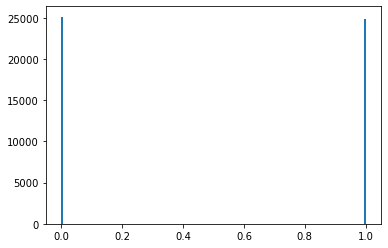

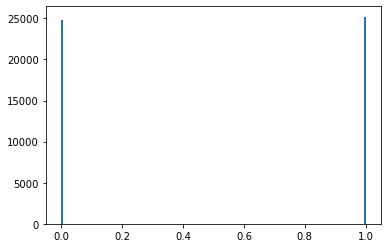

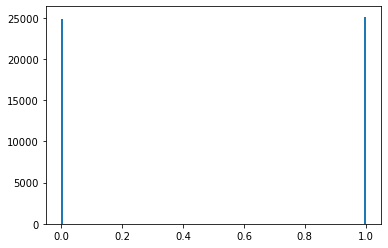

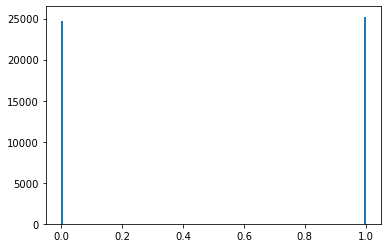

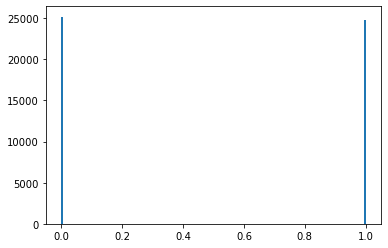

5000
45000


In [3]:
seed = 7
np.random.seed(seed)
exec(open('distribution/twopeak.py').read())
#exec(open('distribution/normal.py').read())
X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
#run_cs()

In [4]:
#GCSOD

def cost_sharing_with_deadline(test,t_c,target):
    temp_max_delay=0
    temp_sum_delay=0
    result=False
    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for item in test:
            if(item>=target/k):
                count+=1;
            else:
                delay+=t_c;
        if(count>=k):
            temp_sum_delay+=delay;
            if(k!=len(test)):
                temp_max_delay=t_c
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay=1
            temp_sum_delay=len(test);
            result=False
            
            
    return temp_max_delay,temp_sum_delay,result

def cost_sharing_with_optimal_deadline(group_data):
    group_data=np.sort(group_data)
    t_c_list=[]
    for i in range(len(group_data)):
        t_c_list.append( 1.0/(number_of_groups-1)/(group_data[i]*(len(group_data)-i))+1e-8 )
        
        
    optimal_max_t_c=1e9
    optimal_sum_t_c=1e9

    
    for ii in range(len(group_data)):
        temp_test=[]
        if(True or t_c_list[ii]<=1):
            for j in range(0,ii):
                temp_test.append(0)
            
            for j in range(ii,len(group_data)):
                temp_test.append(group_data[j]*(t_c_list[ii]))
            
            
            
            temp_max_delay,temp_sum_delay,judge1 = cost_sharing_with_deadline(temp_test,t_c_list[ii],1.0/(number_of_groups-1))
            
            if(judge1):
                if optimal_sum_t_c > t_c_list[ii]:
                    optimal_max_t_c = t_c_list[ii]

                if optimal_sum_t_c > t_c_list[ii]:
                    optimal_sum_t_c = t_c_list[ii]

        
    if(optimal_max_t_c>1):
        optimal_max_t_c=1
    
    if(optimal_sum_t_c>1):
        optimal_sum_t_c=1
    return optimal_max_t_c,optimal_sum_t_c


total_delay=0
test_number=0
op_test=[0.9460855941857127]
for i in range(1):
    print(cost_sharing_with_optimal_deadline(op_test))


(1, 1)


In [5]:
def run_GCSOD():
    nn=0
    max_delay=0
    sum_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        test=X_test[i];
        
        temp_groups=[[]for j in range(number_of_groups)]
        temp_groups_t_c_max=[[]for j in range(number_of_groups)]
        temp_groups_t_c_sum=[[]for j in range(number_of_groups)]
        
        for k in range(len(test)):
            temp_groups[random.randint(0, number_of_groups-1)].append(test[k])
            
        frist_max_id=-1
        frist_t_c_max=-1e9
        second_max_id=-1
        second_t_c_max=-1e9
        temp_total_max_delay=0
        temp_total_sum_delay=0
        
        
        for j in range(number_of_groups):
            temp_groups_t_c_max[j],temp_groups_t_c_sum[j]=cost_sharing_with_optimal_deadline(temp_groups[j])
            
            
            #print(temp_groups_t_c_max[j],temp_groups_t_c_sum[j],1.0/(number_of_groups-1))
            #print()
            if(temp_groups_t_c_max[j]>=frist_t_c_max):
                if(frist_t_c_max>=second_t_c_max):
                    
                    second_t_c_max=frist_t_c_max
                    second_max_id=frist_max_id
                
                frist_t_c_max=temp_groups_t_c_max[j]
                frist_max_id=j
                
            if(temp_groups_t_c_max[j]>=second_t_c_max and temp_groups_t_c_max[j]!=frist_t_c_max):
                second_t_c_max=temp_groups_t_c_max[j]
                second_max_id=j
                
        judge2=False
        for ii in range(number_of_groups):
            if(ii!=frist_max_id):
                test1=copy.deepcopy(temp_groups[ii])
                
                for j in range(len(test1)):
                    test1[j]=test1[j]*frist_t_c_max
                    
                temp_max_delay,temp_sum_delay,judge1=cost_sharing_with_deadline(test1,frist_t_c_max,1.0/(number_of_groups-1))
                
                if(judge1==False):
                    judge2=True;
                
                temp_total_max_delay=max(temp_total_max_delay,temp_max_delay)
                temp_total_sum_delay+=temp_sum_delay
        
        if(len(temp_groups[frist_max_id])!=0):
            temp_max_delay = max(temp_max_delay,second_t_c_max)
            temp_sum_delay = temp_sum_delay+second_t_c_max*len(temp_groups[frist_max_id])
            
            
        temp_total_max_delay=max(temp_total_max_delay,temp_max_delay)
        temp_total_sum_delay+=temp_sum_delay
        
        if(judge2==False):
            max_delay+=temp_total_max_delay
            sum_delay+=temp_total_sum_delay
        else:
            max_delay+=1
            sum_delay+=len(test)
            
        if(nn<10):#temp_group_a_t_c_max<=0.5 and temp_group_b_t_c_max==1  and 
                nn+=1
                for j in range(len(temp_groups)):
                    print("group: ",j," ",temp_groups[j])
                print()
                print(temp_groups_t_c_max)
                print()
                print("frist_max_id",frist_max_id)
                print("frist_t_c_max",frist_t_c_max)
                print("second_max_id",second_max_id)
                print("second_t_c_max",second_t_c_max)
                print("result:",temp_total_max_delay,temp_total_sum_delay)
                print()
                print()
        
    print("max_delay",max_delay/test_number);
    print("sum_delay",sum_delay/test_number);

run_GCSOD()

group:  0   [1, 1, 0, 0]
group:  1   [0]

[0.50000001, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 0.50000001
result: 1 4.50000001


group:  0   [1, 1]
group:  1   [0, 0, 1]

[0.50000001, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 0.50000001
result: 0.50000001 1.5000000300000003


group:  0   [1, 0, 0]
group:  1   [0, 0]

[1, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 1
result: 1 6


group:  0   [1, 1]
group:  1   [0, 0, 1]

[0.50000001, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 0.50000001
result: 0.50000001 1.5000000300000003


group:  0   [0, 0, 0]
group:  1   [0, 0]

[1, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 1
result: 1 8


group:  0   [0, 0, 0]
group:  1   [1, 0]

[1, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 1
result: 1 8


group:  0   [1, 0, 0, 1]
group:  1   [1]

[0.50000001, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_

<ipython-input-4-59b63eaadeff>:34: RuntimeWarning: divide by zero encountered in true_divide
  t_c_list.append( 1.0/(number_of_groups-1)/(group_data[i]*(len(group_data)-i))+1e-8 )
<ipython-input-4-59b63eaadeff>:48: RuntimeWarning: invalid value encountered in multiply
  temp_test.append(group_data[j]*(t_c_list[ii]))


max_delay 0.8610740764571656
sum_delay 3.594648159866966


In [6]:
#Cost Sharing
def run_cs():
    sum_delay=0
    max_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test=X_test[i];
        
        for k in range(Agent_number_n,0,-1):
            count=0;
            delay=0;
            for item in test:
                if(item>=1.0/k):
                    count+=1;
                else:
                    delay+=1;
            if(count>=k):
                temp_delay=delay;
                if temp_delay != 0 :
                    temp_max_delay = 1
                break;
            if(k<=1):
                #print(test);
                temp_delay=Agent_number_n;
                temp_max_delay=1
        sum_delay+=temp_delay
        max_delay+=temp_max_delay
                
    print("max_delay",max_delay/test_number);
    print("sum_delay",sum_delay/test_number);
    
run_cs()

max_delay 0.9682666666666667
sum_delay 2.4943333333333335


[0.51413212 0.27857653 0.6588369  0.73533261 0.21293481]
[[0.46863628 0.55388233 0.39507908 0.88240377 0.54746037]
 [0.80643883 0.5707171  0.55080047 0.70836765 0.62129768]
 [0.4315766  0.40561467 0.327102   0.57487407 0.57830914]
 ...
 [0.93525536 0.12057256 0.53548127 0.40814127 0.36865575]
 [0.60903919 0.51891684 0.41369446 0.82782239 0.85434108]
 [0.15543318 0.25960961 0.47886996 0.7053724  0.21132568]]
[0.46863628 0.80643883 0.4315766  ... 0.93525536 0.60903919 0.15543318]


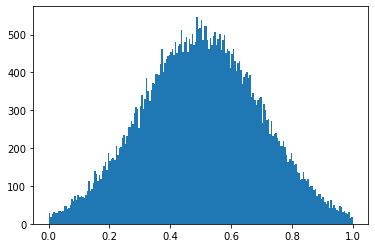

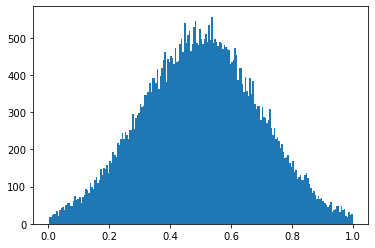

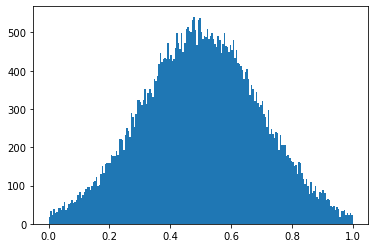

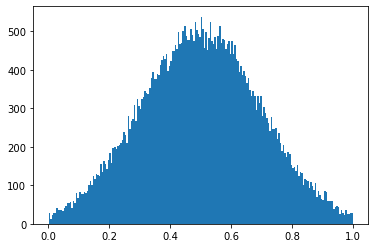

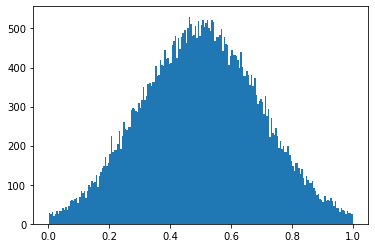

5000
45000
group:  0   [0.5348591237366408, 0.2684112616298756, 0.36360624725943735, 0.6362151583406418]
group:  1   [0.30778200613663487]

[0.9167426013215844, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 0.9167426013215844
result: 0.9167426013215844 0.9167426013215844


group:  0   [0.04377781416538146]
group:  1   [0.5485711213255168, 0.5296501176277747, 0.4107349682085054, 0.6028934517950939]

[1, 0.6086650114008305]

frist_max_id 0
frist_t_c_max 1
second_max_id 1
second_t_c_max 0.6086650114008305
result: 0.6086650114008305 0.6086650114008305


group:  0   [0.6003163686055377, 0.5389272662268831]
group:  1   [0.6313597651577307, 0.2355636530832979, 0.5734925672102176]

[0.9277689898487667, 0.8718508910537411]

frist_max_id 0
frist_t_c_max 0.9277689898487667
second_max_id 1
second_t_c_max 0.8718508910537411
result: 0.9277689898487667 3.5992397618050154


group:  0   [0.7047775008197095, 0.40584235077073316, 0.5941119039348387]
group:  1   [0.513267581347633, 0.5

In [7]:
seed = 7
np.random.seed(seed)
exec(open('distribution/normal.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()

[0.85706606 0.03928826 0.22941845 0.9676663  0.7064674 ]
[[0.83431814 0.87694116 0.79753954 0.34120189 0.17373018]
 [0.58058649 0.30321941 0.18535855 0.87540023 0.25418382]
 [0.91064884 0.8157883  0.10280733 0.763551   0.18743703]
 ...
 [0.9282437  0.78163788 0.1594463  0.97905601 0.25719393]
 [0.37470857 0.82901063 0.11360359 0.84586364 0.8281926 ]
 [0.7906067  0.16944556 0.19090767 0.0398219  0.04960873]]
[0.83431814 0.58058649 0.91064884 ... 0.9282437  0.37470857 0.7906067 ]


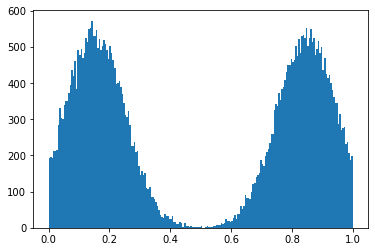

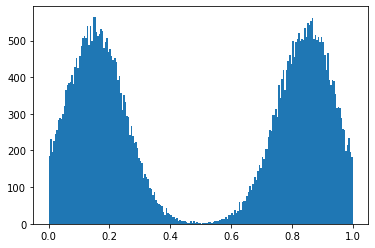

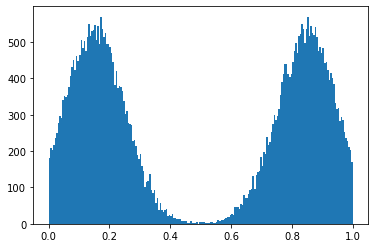

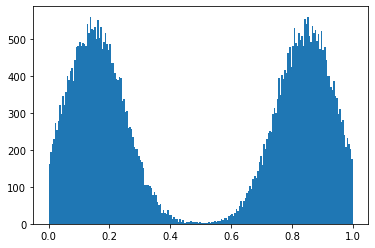

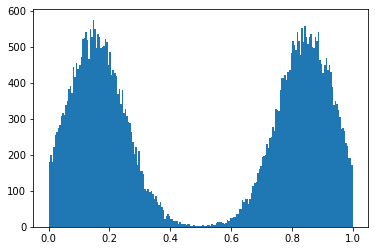

5000
45000
group:  0   [0.9022883622680568, 0.8004921244279757]
group:  1   [0.6342794984751925, 0.00027602867433224043, 0.25358230806085374]

[0.6246157741554506, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 0.6246157741554506
result: 0.6246157741554506 1.8738473224663517


group:  0   [0.8409709364114013, 0.7706933731159825]
group:  1   [0.19572506956076488, 0.9731808544277207, 0.6492385113955077]

[0.6487664551796894, 0.770133006154639]

frist_max_id 1
frist_t_c_max 0.770133006154639
second_max_id 0
second_t_c_max 0.6487664551796894
result: 0.6487664551796894 1.9462993655390683


group:  0   [0.7982459510228953, 0.08478203315368503, 0.591886092997797]
group:  1   [0.284367196949998, 0.06663230424366134]

[0.8447571447175765, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 0.8447571447175765
result: 1 3.689514289435153


group:  0   [0.049238484482135386, 0.2264944769011965, 0.04831611328064095]
group:  1   [0.8089856429344171, 0.747105061291530

In [8]:
seed = 7
np.random.seed(seed)
exec(open('distribution/twopeaknormal.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()

In [9]:
Agent_number_n=10

[0.06925207 0.35707063 0.81282955 0.42770483 0.59985444 0.72816128
 0.82122761 0.76051512 0.00714328 0.42025683]
[[0.97347557 0.95538345 0.42462553 ... 0.63650234 0.76108474 0.18802993]
 [0.23783677 0.66459076 0.3741999  ... 0.21199017 0.93517469 0.31604711]
 [0.45861424 0.9552804  0.6050889  ... 0.13753772 0.24868187 0.3719452 ]
 ...
 [0.00135324 0.92930247 0.50282703 ... 0.39938354 0.80417017 0.3030602 ]
 [0.82438031 0.98801145 0.94356356 ... 0.94623534 0.67942117 0.35917411]
 [0.95749473 0.57971146 0.48221346 ... 0.45168093 0.5083954  0.24159483]]
[0.97347557 0.23783677 0.45861424 ... 0.00135324 0.82438031 0.95749473]


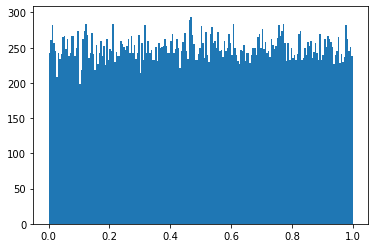

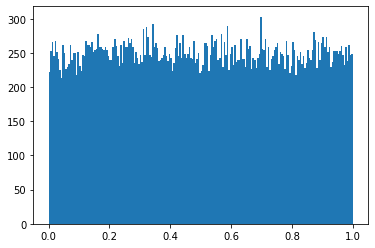

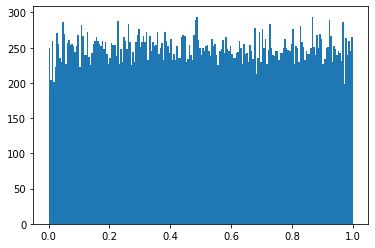

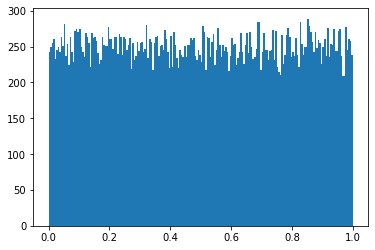

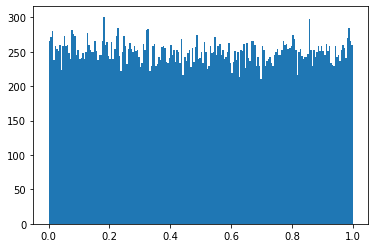

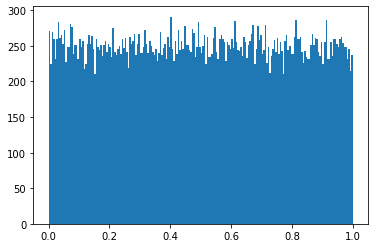

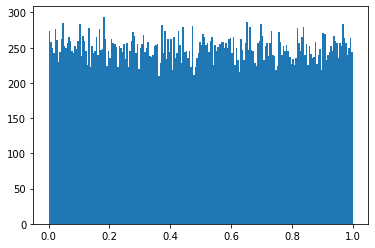

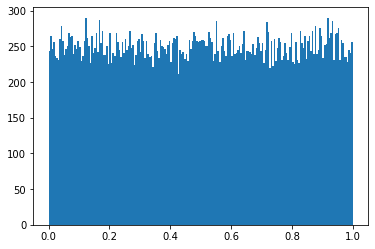

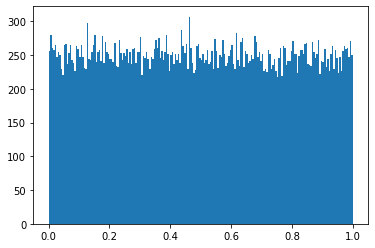

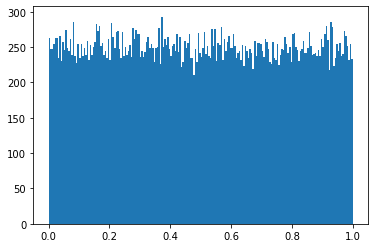

5000
45000
group:  0   [0.4302698525970772, 0.4065732603252852]
group:  1   [0.11955097322002162, 0.7231359234772915, 0.7477861687888915, 0.7316455656728776, 0.3299107229154601, 0.34109601406659384, 0.30242712102540636, 0.18852534990075742]

[1, 0.4609553055555816]

frist_max_id 0
frist_t_c_max 1
second_max_id 1
second_t_c_max 0.4609553055555816
result: 1 2.921910611111163


group:  0   [0.40684573849380024, 0.07106341863634913, 0.6805478280369316, 0.764809522192925, 0.7718718291428536]
group:  1   [0.7989523779869736, 0.20748116187549037, 0.14850357177570483, 0.8198302229615656, 0.09732045308087811]

[0.4898014899266161, 0.6258195378920018]

frist_max_id 1
frist_t_c_max 0.6258195378920018
second_max_id 0
second_t_c_max 0.4898014899266161
result: 0.6258195378920018 3.7006465254170844


group:  0   [0.6054179172507329, 0.7109328900629859, 0.8736410176141925, 0.75219800202605, 0.18649319600897785, 0.8379187603712152]
group:  1   [0.7164761348789744, 0.09182331673482724, 0.308111286382062

In [10]:
seed = 7
np.random.seed(seed)
exec(open('distribution/uniform.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()

[0.46079454 0.38184604 0.44005775 0.75937704 0.80591593 0.63388364
 0.60974902 0.6353258  0.49755156 0.48486731]
[[0.87201113 0.20054527 0.59526754 ... 0.33755828 0.33658395 0.53846154]
 [0.47846659 0.21971507 0.46661005 ... 0.69515653 0.40636836 0.30079682]
 [0.56450355 0.21218269 0.57814536 ... 0.28712334 0.21701084 0.37076454]
 ...
 [0.43864059 0.39519556 0.25913795 ... 0.16610715 0.36812844 0.25688583]
 [0.57064284 0.80187086 0.32699813 ... 0.55452639 0.12878824 0.7224619 ]
 [0.1787494  0.46602704 0.35186737 ... 0.55845853 0.07381374 0.64903735]]
[0.87201113 0.47846659 0.56450355 ... 0.43864059 0.57064284 0.1787494 ]


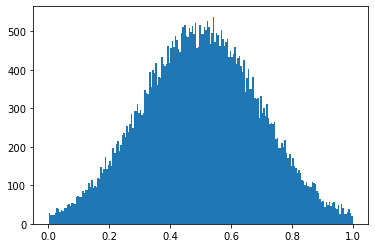

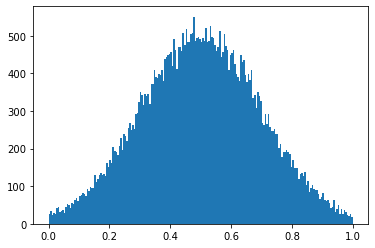

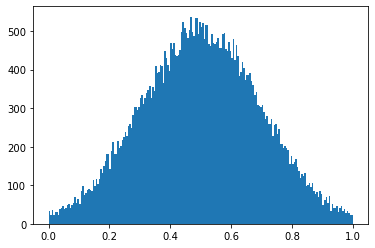

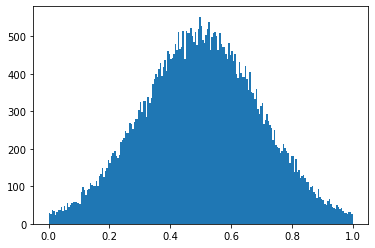

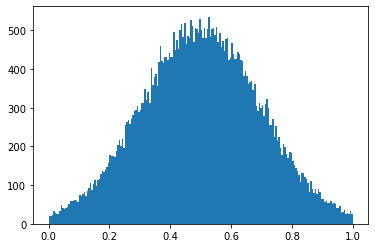

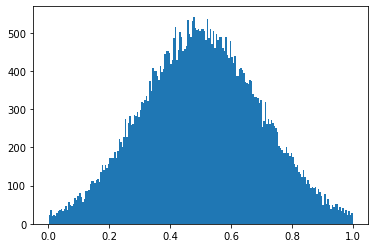

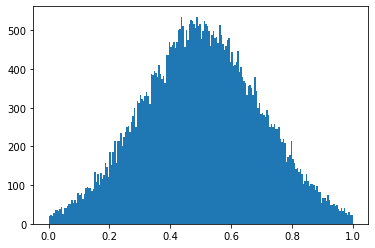

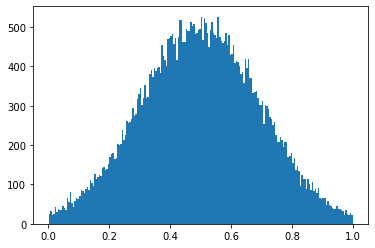

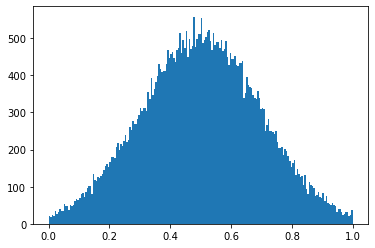

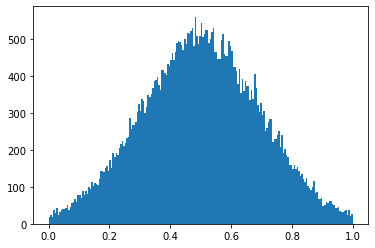

5000
45000
group:  0   [0.3571753393279459, 0.5787396226256655, 0.34469241115586546, 0.5806575183838196]
group:  1   [0.5505476772486086, 0.35952543028746153, 0.09477315009129678, 0.09700314148602274, 0.439696662558134, 0.31381411077308174]

[0.7252843269992311, 0.7966499738404547]

frist_max_id 1
frist_t_c_max 0.7966499738404547
second_max_id 0
second_t_c_max 0.7252843269992311
result: 0.7252843269992311 4.351705961995386


group:  0   [0.7081093430521871, 0.31670016900208, 0.6097793136163069, 0.53930163931886, 0.6065884401292225, 0.7604793162969394, 0.4336309674507729, 0.5943589682140641]
group:  1   [0.4720751954281515, 0.14680827882219233]

[0.30904165666951006, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 0.30904165666951006
result: 0.30904165666951006 0.6180833133390201


group:  0   [0.39622339839761384, 0.37582209296839725, 0.5710219872621931, 0.393996960984783]
group:  1   [0.5864268680689537, 0.4837528680418992, 0.7146462271632061, 0.3408341644390033, 0.3

In [11]:
seed = 7
np.random.seed(seed)
exec(open('distribution/normal.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()

In [12]:
run_cs()

max_delay 0.15688888888888888
sum_delay 0.1744


[0.83039727 0.09092302 0.12002888 0.97968852 0.30295796 0.21694182
 0.20487451 0.9176629  0.84877578 0.14243365]
[[0.33600557 0.70027264 0.19763377 ... 0.76877914 0.06829198 0.86923077]
 [0.83923329 0.00985753 0.83330503 ... 0.94757826 0.10318418 0.05039841]
 [0.18225178 0.70609134 0.18907268 ... 0.74356167 0.00850542 0.78538227]
 ...
 [0.87248439 0.98835127 0.15573997 ... 0.16568351 0.88563483 0.1813785 ]
 [0.218171   0.089527   0.95035543 ... 0.76096434 0.34071366 0.0967878 ]
 [0.15181202 0.98189429 0.87781035 ... 0.08066946 0.16453014 0.96681908]]
[0.33600557 0.83923329 0.18225178 ... 0.87248439 0.218171   0.15181202]


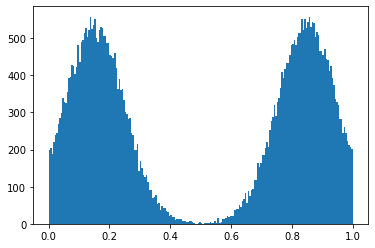

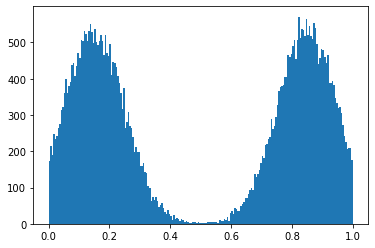

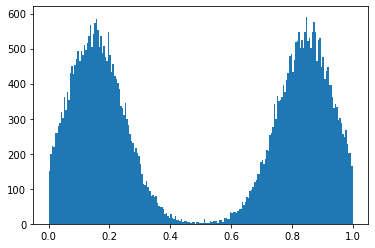

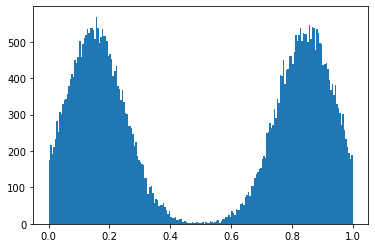

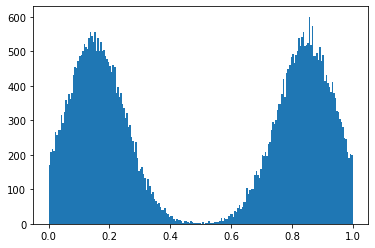

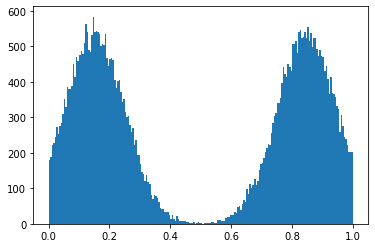

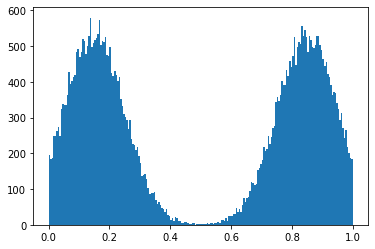

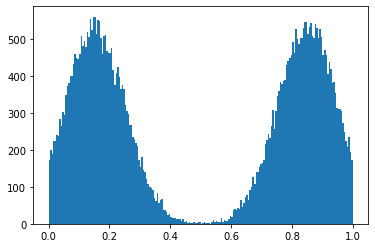

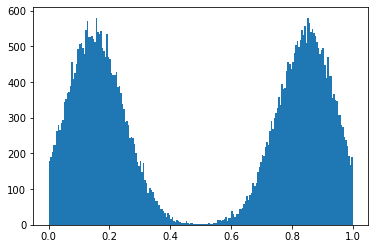

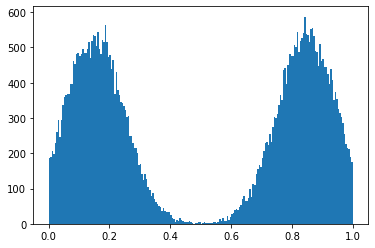

5000
45000
group:  0   [0.7972600529065247, 0.8906787668678185, 0.742160667357152, 0.773350851325073, 0.12036665220802593, 0.7036136821384847]
group:  1   [0.32090578711245155, 0.866973113178076, 0.9698840435878198, 0.7400829950473554]

[0.2842468987076533, 0.450399945634252]

frist_max_id 1
frist_t_c_max 0.450399945634252
second_max_id 0
second_t_c_max 0.2842468987076533
result: 0.450399945634252 2.037787486099117


group:  0   [0.1944636886659291, 0.8499484258310345, 0.16552245013882125, 0.11511572198788331, 0.19890407803760907, 0.11312108202282403]
group:  1   [0.6962264694865281, 0.030357490865898257, 0.06878791405266192, 0.056484823507066656]

[1, 1]

frist_max_id 1
frist_t_c_max 1
second_max_id 0
second_t_c_max 1
result: 1 16


group:  0   [0.8392662480068895, 0.21202547369380276, 0.10776428183507417, 0.14624460986915422, 0.9331978098142909]
group:  1   [0.16326136005356104, 0.15329246602417576, 0.9187730413719145, 0.12132191619256329, 0.6953763663625159]

[0.5957585087927402, 0.

In [13]:
seed = 7
np.random.seed(seed)
exec(open('distribution/twopeaknormal.py').read())

X_train,  X_test = train_test_split(value_list, test_size=0.9, random_state=seed)

dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
run_GCSOD()

In [14]:
run_cs()

max_delay 0.7508666666666667
sum_delay 1.7432222222222222
